In [48]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

# Optional: Configure plotting style for a consistent look
plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2019-01-01'
END_DATE = "2024-01-01"  # Replace this with your actual END_DATE if it's variable
end_date_dt = pd.to_datetime(END_DATE)
start_date_6_month_dt = end_date_dt - pd.DateOffset(months=6)
start_date_6_month = start_date_6_month_dt.strftime('%Y-%m-%d')
end_date_6_month = end_date_dt.strftime('%Y-%m-%d')

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_47928\4173998976.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [49]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC         VIXY         VTI
Date                                                     
2019-01-02  91.825172  13.549266  2996.800049  116.516731
2019-01-03  92.204285  13.661166  3137.600098  113.816597
2019-01-04  91.928596  13.847668  2885.600098  117.584023
2019-01-07  91.773460  13.950241  2824.800049  118.769905
2019-01-08  91.704536  14.090117  2765.600098  119.992271
Data covers 1258 trading days with 4 assets.


In [50]:
# Data Preprocessing Step
# Objective: Prepare data by calculating daily returns and normalizing for model input

def preprocess_data(data):
    """
    Prepares data for the LSTM model by calculating returns and normalizing prices.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets

    Returns:
    - normalized_data: DataFrame with prices normalized to start at 1 for each asset
    - returns: DataFrame with daily returns for each asset
    """
    # Calculate daily returns as percentage changes
    returns = data.pct_change().dropna()
    
    # Normalize prices so each series starts at 1
    normalized_data = data / data.iloc[0]
    
    return normalized_data, returns

# Run preprocessing and display sample data
normalized_data, returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-02  1.000000  1.000000  1.000000  1.000000
2019-01-03  1.004129  1.008259  1.046983  0.976826
2019-01-04  1.001126  1.022023  0.962894  1.009160
2019-01-07  0.999437  1.029594  0.942605  1.019338
2019-01-08  0.998686  1.039917  0.922851  1.029829

Sample daily returns:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-03  0.004129  0.008259  0.046983 -0.023174
2019-01-04 -0.002990  0.013652 -0.080316  0.033101
2019-01-07 -0.001688  0.007407 -0.021070  0.010085
2019-01-08 -0.000751  0.010027 -0.020957  0.010292
2019-01-09  0.000846  0.019854 -0.023141  0.004713


In [51]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")

    def step(self, action):
        normalized_action = np.array(action) / np.sum(action)
        
        self.rebalance(normalized_action)
        portfolio_returns = self.calculate_daily_returns()

        self.current_value *= (1 + portfolio_returns[-1])
        self.portfolio_history.append(self.current_value)

        daily_returns = np.array(self.portfolio_history)
        returns = daily_returns[1:] / daily_returns[:-1] - 1
        mean_returns = np.mean(returns)
        std_returns = np.std(returns)
        reward = mean_returns / std_returns if std_returns != 0 else 0

        normalized_prices = self.assets / self.assets.iloc[0]
        next_state = normalized_prices.values[-1]

        done = self.current_value <= self.initial_cash * 0.75

        return next_state, reward, done
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(final_allocations, returns, target_volatility=0.1, rolling_window=50):
        """
        Scales the final allocations based on target volatility.
        
        Parameters:
        - final_allocations: Array of final asset allocations (e.g., [0.3, 0.7] for 30% in asset A, 70% in asset B).
        - returns: DataFrame of daily returns for each asset.
        - target_volatility: Desired target volatility (e.g., 0.1 for 10%).
        - rolling_window: Number of days for calculating rolling volatility.
        
        Returns:
        - scaled_allocations: Adjusted allocations to achieve the target volatility.
        """
        # Calculate portfolio returns based on final allocations
        portfolio_returns = returns.dot(final_allocations)
        
        # Calculate current portfolio volatility over the rolling window (annualized)
        current_volatility = portfolio_returns.rolling(rolling_window).std().iloc[-1] * np.sqrt(252)
        
        # Calculate scaling factor
        scaling_factor = target_volatility / current_volatility if current_volatility > 0 else 1
        
        # Apply scaling to allocations
        scaled_allocations = final_allocations * scaling_factor
        return scaled_allocations


In [52]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Preprocess the training data
    normalized_data, _ = preprocess_data(train_data)

    # Get allocations from the model
    allocations = model.get_allocations(normalized_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [53]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

def calculate_expected_annual_return_with_actual_prices(final_allocations, start_date, end_date, initial_cash):
    """
    Buys stock at the actual start price for the six-month period and calculates expected annual return.
    
    Parameters:
    - final_allocations: Numpy array of final asset allocations.
    - start_date: Start date for the 6-month period before the testing end date.
    - end_date: End date for the 6-month period.
    - initial_cash: The starting cash amount for the new portfolio.
    
    Returns:
    - expected_annual_return: Extrapolated annual return based on the 6-month performance.
    """
    # Fetch actual price data for the six-month period
    data_6_month = get_data(TICKERS, start_date, end_date)
    
    # Get initial prices to buy shares
    initial_prices = data_6_month.iloc[0]  # First row gives prices on the start date
    
    # Calculate dollar allocation per asset
    dollar_allocations = final_allocations * initial_cash
    
    # Calculate shares purchased for each asset
    shares = dollar_allocations / initial_prices
    
    # Track portfolio value over the six-month period using actual prices
    portfolio_values = data_6_month.dot(shares)
    
    # Calculate the total return over the six-month period
    total_return_6_month = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Annualize the return
    expected_annual_return = (1 + total_return_6_month) ** (12 / 6) - 1
    
    return expected_annual_return


In [54]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3774
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3099
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2377
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1671
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1049
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0557
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0201
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: -0.0040
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: -0.0197
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -0.0299
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: -0.0367
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -0.0418
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: -0.0459
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.0497
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: -0.0535
Epoch 16/100


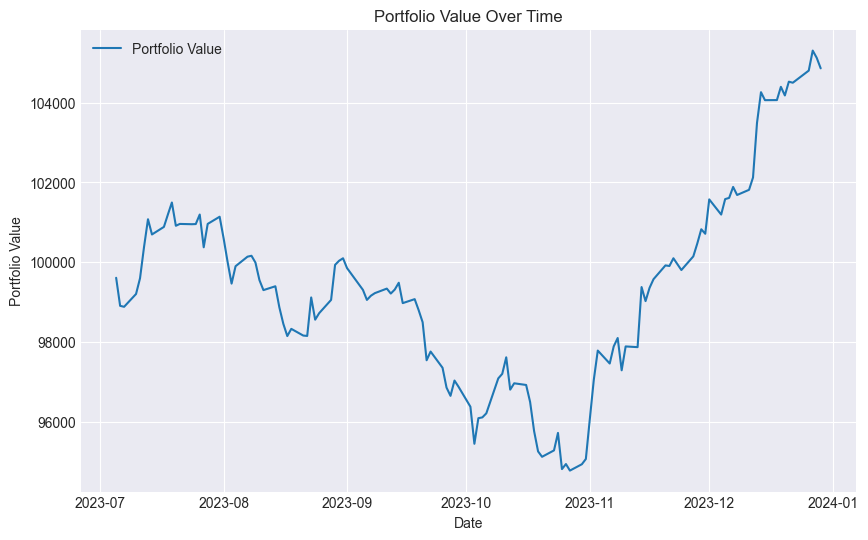

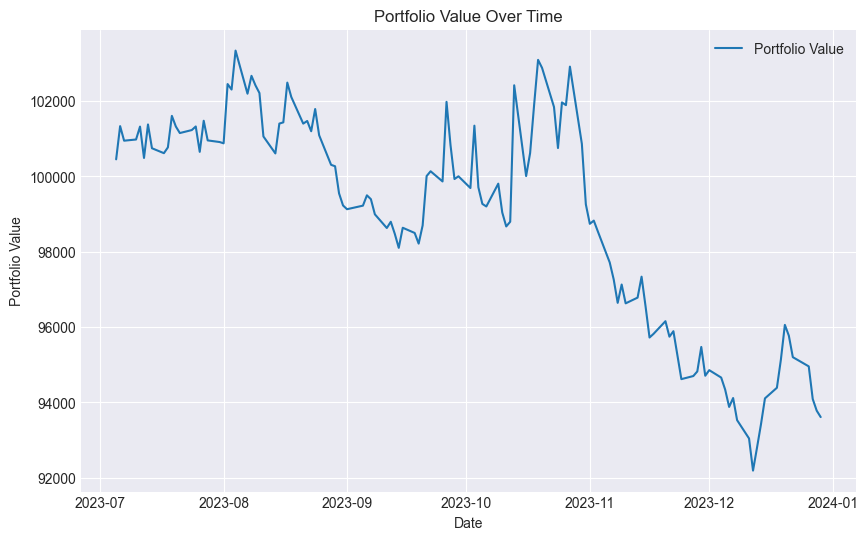

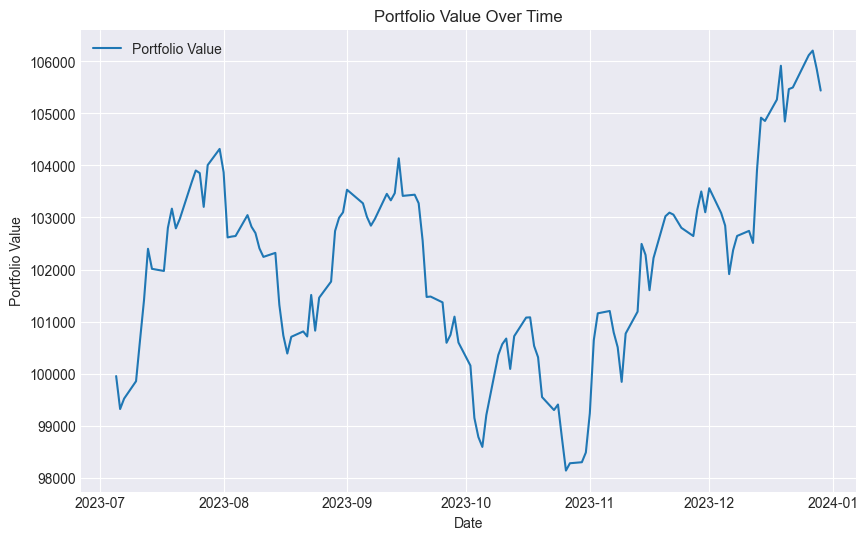

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed


LSTM Portfolio Metrics:
Weights:[0.6804785  0.00654555 0.00244242 0.31053352], Shares:{'AGG': 729, 'DBC': 30, 'VIXY': 2, 'VTI': 143}
{'Sharpe Ratio': 1.4286195978741176, 'Sortino Ratio': 2.583891250514091, 'Max Drawdown': 0.06623211266743026}
Expected Annual Return: 0.09865790532253738

Equal-Weighted Portfolio Metrics:
Weights:[0.25 0.25 0.25 0.25], Shares:{'AGG': 267, 'DBC': 1155, 'VIXY': 252, 'VTI': 115}
{'Sharpe Ratio': -1.0649265629963993, 'Sortino Ratio': -1.8894097626635677, 'Max Drawdown': 0.10790483417232902}
Expected Annual Return: -0.11559560444756334

Mean-Variance Optimized Portfolio Metrics:
Weights:[2.02594816e-01 3.08963559e-01 5.42101086e-19 4.88441625e-01], Shares:{'AGG': 217, 'DBC': 1427, 'VIXY': 0, 'VTI': 225}
{'Sharpe Ratio': 1.3045138915359904, 'Sortino Ratio': 2.438004531743855, 'Max Drawdown': 0.05927520408807499}
Expected Annual Return: 0.1086030579152546


In [55]:
# Step 1: Data Preparation for Training and Testing
train_data = get_data(TICKERS, START_DATE, END_DATE)
normalized_train_data, training_returns = preprocess_data(train_data)

testing_data = get_data(TICKERS, start_date_6_month, end_date_6_month)
normalized_testing_data, testing_returns = preprocess_data(testing_data)

# Step 2: Train and Rebalance Portfolio in Training Phase (rebalancing every two years)
training_portfolio = Portfolio(100000, normalized_train_data)
model = Model()
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, model=model)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)

# Step 5: Baseline Strategies Setup and Evaluation
# Equal-Weighted and Mean-Variance Optimized Portfolios
equal_weights = equal_weighted_strategy(training_returns)
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)

equal_weight_portfolio = Portfolio(100000, normalized_testing_data)
mv_optimized_portfolio = Portfolio(100000, normalized_testing_data)

equal_weight_portfolio.rebalance(equal_weights)
mv_optimized_portfolio.rebalance(mv_optimized_weights)

equal_weight_portfolio.calculate_daily_returns()
mv_optimized_portfolio.calculate_daily_returns()
ew_shares = equal_weight_portfolio.calculate_initial_shares(100000,initial_prices)
mv_shares = mv_optimized_portfolio.calculate_initial_shares(100000,initial_prices)
equal_weight_portfolio.plot_portfolio_value()
mv_optimized_portfolio.plot_portfolio_value()
# Step 6: Calculate Performance Metrics for Baseline Portfolios
equal_weight_metrics = calculate_metrics(equal_weight_portfolio.portfolio_history)
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)

# Step 7: Calculate Expected Annual Return with Actual Prices
start_date_6_month = '2023-07-01'
end_date_6_month = '2024-01-01'
expected_annual_return = calculate_expected_annual_return_with_actual_prices(final_allocations, start_date_6_month, end_date_6_month, 100000)
print("\nLSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)
print(f"Expected Annual Return: {expected_annual_return}")

print("\nEqual-Weighted Portfolio Metrics:")
print(f"Weights:{equal_weights}, Shares:{ew_shares}")
print(equal_weight_metrics)
expected_annual_return_ew = calculate_expected_annual_return_with_actual_prices(equal_weights, start_date_6_month, end_date_6_month, 100000)
print(f"Expected Annual Return: {expected_annual_return_ew}")

print("\nMean-Variance Optimized Portfolio Metrics:")
print(f"Weights:{mv_optimized_weights}, Shares:{mv_shares}")
print(mv_optimized_metrics)
expected_annual_return_mv = calculate_expected_annual_return_with_actual_prices(mv_optimized_weights, start_date_6_month, end_date_6_month, 100000)
print(f"Expected Annual Return: {expected_annual_return_mv}")


[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3728
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3267
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2708
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2095
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1504
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0638
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0365
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0161
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.6709e-05
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: -0.0124
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: -0.0218
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: -0.0280
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: -0.0316
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: -0.0334
Epoch 16/100

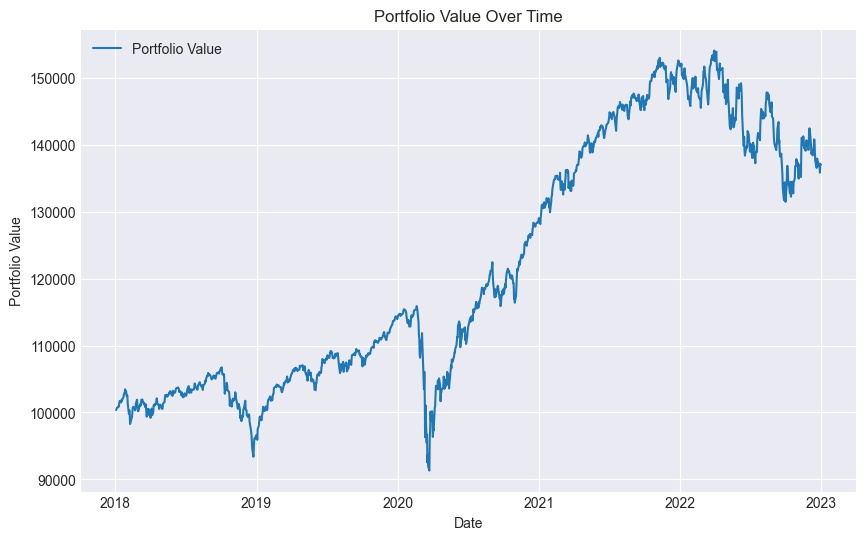

Test Metrics: {'Sharpe Ratio': 0.5759609779512694, 'Sortino Ratio': 0.6851967851990516, 'Max Drawdown': 0.21190181235447725}
Final Allocations: [0.30809653 0.19267844 0.01518991 0.48403516]


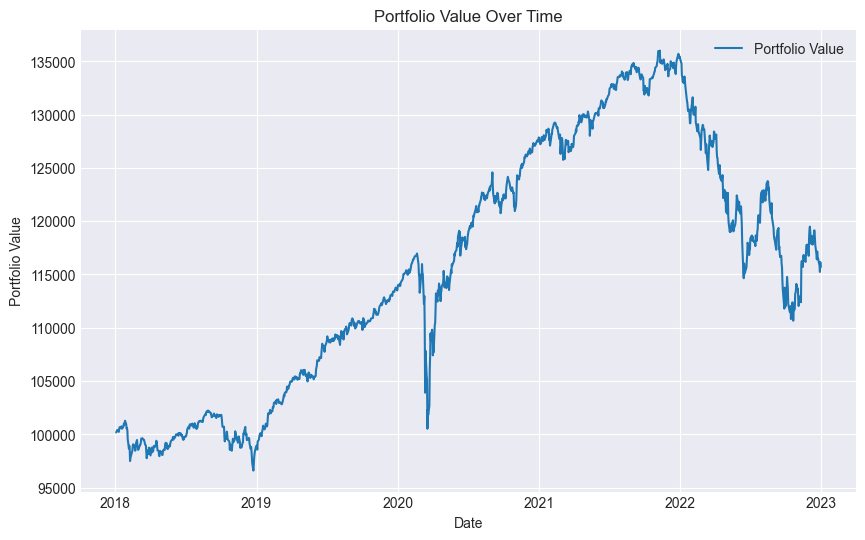

Mean-Variance Optimized Metrics: {'Sharpe Ratio': 0.39557901846662163, 'Sortino Ratio': 0.4463798279450074, 'Max Drawdown': 0.18634775041013785}
Mean-Variance Optimized Allocations: [7.06418865e-01 3.48009791e-15 1.55040911e-17 2.93581135e-01]


In [56]:
# Step 1: Fetch data for a 10-year period
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
start_date = '2013-01-01'  # Start date for 10 years of data
end_date = '2023-01-01'    # End date for testing
data = get_data(tickers, start_date, end_date)

# Step 2: Define train-test split (e.g., 50% for training, 50% for testing)
split_ratio = 0.5
split_index = int(len(data) * split_ratio)

# Step 3: Split and preprocess data
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

normalized_train, _ = preprocess_data(train_data)
normalized_test, _ = preprocess_data(test_data)

# Step 4: Train model on training data
model = Model()
training_portfolio = Portfolio(initial_cash=100000, assets=normalized_train)
training_returns = training_portfolio.assets.pct_change().dropna()
final_allocations = train_and_rebalance_portfolio(training_portfolio, model=model)

# Step 5: Test on the holdout set using final allocations
testing_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
testing_portfolio.rebalance(final_allocations)
testing_portfolio.calculate_daily_returns()
testing_portfolio.plot_portfolio_value()
# Calculate test performance metrics
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print(f"Test Metrics: {metrics}")
print(f"Final Allocations: {final_allocations}")
# Step 6: Use mean-variance optimization for comparison
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)
mv_optimized_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
mv_optimized_portfolio.rebalance(mv_optimized_weights)
mv_optimized_portfolio.calculate_daily_returns()
mv_optimized_portfolio.plot_portfolio_value()
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)
print(f"Mean-Variance Optimized Metrics: {mv_optimized_metrics}")
print(f"Mean-Variance Optimized Allocations: {mv_optimized_weights}")


In [ ]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    """
    Performs rolling validation with a specified allocation strategy, aligned with the paper's periodic retraining and testing.
    
    Parameters:
    - data: DataFrame of historical prices.
    - allocation_strategy: Function that computes portfolio allocations based on training data.
    - train_years: Number of years for the training period in each roll.
    - test_months: Number of months for the testing period in each roll.
    - initial_cash: Initial investment amount.

    Returns:
    - results: List of dictionaries with performance metrics for each roll.
    """
    results = []
    start_date = data.index[0]
    
    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)
        
        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break
        
        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]
        
        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, _ = preprocess_data(test_data)
        
        # Conditional handling for strategy-specific allocation
        if allocation_strategy == train_and_rebalance_portfolio:
            # LSTM-based strategy with a single training session
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_train)
            final_allocations = allocation_strategy(training_portfolio, model=model)
        else:
            # Non-LSTM strategy (e.g., equal-weighted or mean-variance) without periodic rebalancing
            if allocation_strategy == mean_variance_optimized_strategy:
                final_allocations = allocation_strategy(train_returns)  # Mean-variance uses returns
            else:
                final_allocations = allocation_strategy(normalized_train)  # Equal-weighted and other strategies use prices
        
        # Apply the final allocations to the test data
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_test)
        testing_portfolio.rebalance(final_allocations)
        testing_portfolio.calculate_daily_returns()
        
        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)
        
        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })
        
        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)
    
    return results


In [58]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
data = get_data(tickers, '2006-01-01', '2020-04-01')

# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)

# Rolling validation with equal-weighted strategy
equal_weight_results = generalized_rolling_validation(data, equal_weighted_strategy)
print("Equal-Weighted Results:", equal_weight_results)

# Rolling validation with mean-variance optimization
mvo_results = generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)


[*********************100%%**********************]  4 of 4 completed

Epoch 1/100



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4190
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4143
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4098
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4055
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4012
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3970
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3929
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3888
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3847
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3806
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3766
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3726
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3688
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3652
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3617
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━